# Fotometría de apertura para todos los filtros

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path

from astropy.coordinates import SkyCoord

from astropy.table import Table
from astropy.io import ascii
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from photutils.aperture import SkyCircularAperture
from photutils.aperture import SkyCircularAnnulus
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry

h = '/home/jpcalderon/'
mosaic = h + '2022/Antlia/data/2020+2021/Valdes/mosaic/'

Las siguientes tres celdas solo son necesarias si se quiere instalar 'calviacat'.

In [21]:
cwd = os.getcwd()

if not os.path.isdir ( 'github/mastcasjobs' ):
    !git clone https://github.com/rlwastro/mastcasjobs 'github/mastcasjobs'

if not os.path.isdir ( 'github/calviacat' ):
    !git clone https://github.com/mkelley/calviacat 'github/calviacat'

In [22]:
os.chdir('github/calviacat')
!python setup.py install 
os.chdir(cwd)

running install
/home/jpcalderon/opt/miniconda3/envs/work/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
/home/jpcalderon/opt/miniconda3/envs/work/lib/python3.7/site-packages/setuptools/command/easy_install.py:147: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  EasyInstallDeprecationWarning,
running bdist_egg
running egg_info
writing calviacat.egg-info/PKG-INFO
writing dependency_links to calviacat.egg-info/dependency_links.txt
writing requirements to calviacat.egg-info/requires.txt
writing top-level names to calviacat.egg-info/top_level.txt
reading manifest file 'calviacat.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'calviacat.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running inst

In [23]:
os.chdir('github/mastcasjobs')
!python setup.py install 
os.chdir(cwd)

running install
/home/jpcalderon/opt/miniconda3/envs/work/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
/home/jpcalderon/opt/miniconda3/envs/work/lib/python3.7/site-packages/setuptools/command/easy_install.py:147: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  EasyInstallDeprecationWarning,
running bdist_egg
running egg_info
creating mastcasjobs.egg-info
writing mastcasjobs.egg-info/PKG-INFO
writing dependency_links to mastcasjobs.egg-info/dependency_links.txt
writing requirements to mastcasjobs.egg-info/requires.txt
writing top-level names to mastcasjobs.egg-info/top_level.txt
writing manifest file 'mastcasjobs.egg-info/SOURCES.txt'
reading manifest file 'mastcasjobs.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license f

In [2]:
import calviacat as cvc
# https://github.com/mkelley/calviacat
import sqlite3

## Utilizando la lista de objetos que usamos para registrar las imagenes, preparamos la lista de coordenadas celestes para la fotometría

In [3]:
if os.path.isfile('gaia_N3268.fits'):
    gpandas = Table.read ( 'gaia_N3268.fits', format = 'fits' ).to_pandas()
else:
    # Query tomado de: https://arxiv.org/pdf/1804.09378.pdf
    from astroquery.gaia import Gaia

    query = "SELECT * \
             from gaiaedr3.gaia_source \
             where 1 = CONTAINS( POINT ( 'ICRS', ra, dec ), CIRCLE ( 'ICRS', " + ra + ", " + dec + ", 2.0 ) ) \
              AND parallax_over_error > 10 \
              AND phot_g_mean_flux_over_error>50 \
              AND phot_rp_mean_flux_over_error>20 \
              AND phot_bp_mean_flux_over_error>20 \
              AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
              AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
              AND visibility_periods_used>8 \
              AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"

    job = Gaia.launch_job_async ( query, dump_to_file = True, output_format = 'fits', 
                             output_file = 'gaia_N3268.fits' )
    gtable = job.get_results()
    gpandas = gtable.to_pandas() # Convierte la tabla de gaia a pandas
    
print ( "[*] Cant. de resultados:", len(gpandas) )

[*] Cant. de resultados: 28366


In [4]:
positions = SkyCoord( gpandas['ra'].tolist() * u.deg, gpandas['dec'].tolist() * u.deg, frame = 'fk5' )
# Con esto puedo crear un archivo x,y con las coordenadas
# pd.DataFrame({'ra':positions.ra.deg, 'dec':positions.dec.deg}).to_csv ( "output/positions.csv", 
#                                                                       index = False, header = None )
print(len(positions))
positions

28366


<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(157.37300584, -34.33602071), (157.36975126, -34.33321571),
     (157.36639401, -34.3242968 ), ..., (157.46718349, -35.73326795),
     (157.51632173, -35.70830013), (157.48191159, -35.70474985)]>

## Se hace fotometria con la lista de coordenadas celestes, para una apertura de 6px.

In [5]:
if os.path.isfile ( 'photometry_DECam.pkl' ):
    photometry = pd.read_pickle ( 'photometry_DECam.pkl' )
else:
    photometry =  pd.DataFrame()
    phot_filters = pd.DataFrame()

    for filter in [ 'g', 'r', 'i', 'z' ]:
        print ( "[*] Filter: ", filter )   
        image = mosaic + 'antlia0' + filter + '-r.fits' # Uso las imagenes registradas

        phot_table = pd.DataFrame()

        with fits.open(image) as hdul: 
            hdr = hdul[0].header 
            data = hdul[0].data  
            wcs   = WCS ( hdr )

        aperture = SkyCircularAperture ( positions, r = 6.0 * u.arcsec )
        anncielo = SkyCircularAnnulus ( positions, 7.0 * u.arcsec, 9.0 * u.arcsec )
        apers = [ aperture, anncielo ]
        phot_table = aperture_photometry ( data, apers, wcs = wcs )

        bkg_mean = phot_table['aperture_sum_1'] / anncielo.to_pixel(wcs).area 
        bkg_sum = bkg_mean * aperture.to_pixel(wcs).area                   

        phot_table['flux corrected'] = phot_table['aperture_sum_0'] - bkg_sum 
        #==============================================================================================
        # Agregado para calcular los errores
        bg_method = 'mode'
        bg_phot = aperture_stats_tbl(data, anncielo.to_pixel(wcs), sigma_clip=True)
        ap_area = aperture.to_pixel(wcs).area
        phot_table['flux_error'] = compute_phot_error ( phot_table['flux corrected'], bg_phot, bg_method, ap_area )
        #==============================================================================================                      
        phot_table [ filter + '_decam' ] = 25.0 - 2.5 * np.log10( phot_table['flux corrected'] ) # / exptime ) 
        phot_filters [ filter + '_decam' ] = phot_table [ filter + '_decam' ]
        # Agregado para calcular los errores
        phot_filters [ filter + '_decam_err' ] = 1.0857 * phot_table['flux_error'] / phot_table['flux corrected']
    print ( '\n[*] done!')

    photometry = ( phot_table[[ 'id','xcenter','ycenter','sky_center' ]].to_pandas() ).join(phot_filters)
    photometry.to_pickle ( 'photometry_DECam.pkl' )

In [7]:
photometry.rename(columns = {'g_decam_':'g_decam','r_decam_':'r_decam','i_decam_':'i_decam','z_decam_':'z_decam'}, inplace = True)

In [8]:
phot = photometry.replace([np.inf, -np.inf], np.nan).replace(0, np.nan).dropna( how = "any" )
phot

,id,xcenter,ycenter,sky_center.ra,sky_center.dec,g_decam,g_decam_err,r_decam,r_decam_err,i_decam,i_decam_err,z_decam,z_decam_err
0,1,16687.503339,27459.194253,157.373006,-34.336021,8.447336,0.000536,7.866382,0.000412,8.526192,0.000562,10.414287,0.001448
1,2,16723.390563,27496.559947,157.369751,-34.333216,8.856104,0.000650,8.105610,0.000462,8.720395,0.000618,10.527898,0.001538
2,3,16760.520776,27615.466369,157.366394,-34.324297,8.561087,0.000567,7.599375,0.000367,8.175102,0.000482,9.544273,0.000930
3,4,16347.942554,27731.414576,157.403867,-34.315638,9.303864,0.000794,8.815568,0.000641,9.540813,0.000916,11.300666,0.002409
4,5,16646.453946,27891.581408,157.376782,-34.303605,6.034395,0.000186,6.098576,0.000199,6.664962,0.000256,8.230596,0.000512
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28361,28362,15094.361932,8580.612804,157.517996,-35.751874,13.332313,0.005586,11.631497,0.002584,11.239470,0.002118,12.552322,0.005762
28362,28363,15224.881685,8529.523461,157.505935,-35.755707,11.270895,0.001997,9.824556,0.001042,10.146021,0.001212,11.684815,0.003321
28363,28364,15644.292026,8828.664191,157.467183,-35.733268,8.557354,0.000563,7.967394,0.000430,8.723621,0.000613,10.626494,0.001650
28364,28365,15112.387312,9161.629633,157.516322,-35.708300,11.076893,0.001808,9.969542,0.001101,10.503498,0.001433,12.135025,0.004513


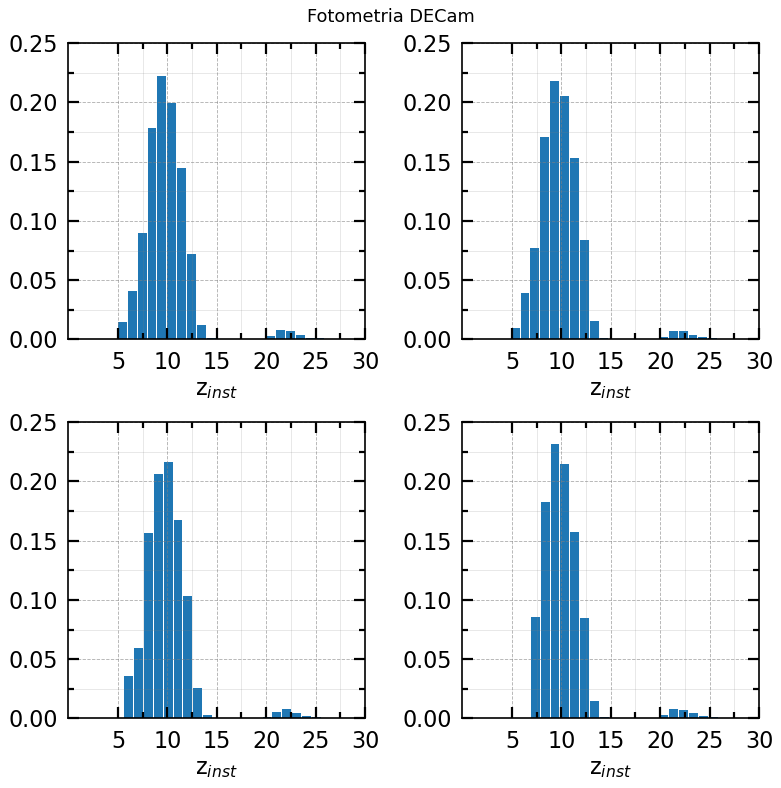

In [11]:
def mkhist(f):
    min = phot[f].min(); max = phot[f].max()
    bins = np.arange ( min, max, 1.0 )
    frq, edges = np.histogram ( phot, bins = bins, density = True ) #, range=(0, 50))
    return frq, edges

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots ( ncols = 2, nrows = 2, figsize = (10, 10), dpi = 80 )
#fig.subplots_adjust ( top = 0.2 )
fig.suptitle ( 'Fotometria DECam', fontsize = 16 )

for f, a in zip([ 'g_decam', 'r_decam', 'i_decam', 'z_decam'], [ax0, ax1, ax2, ax3]):
    frq, edges = mkhist(f)
    a.bar ( edges[:-1]+0.5*(edges[:-1][1] - edges[:-1][0]), frq, np.diff(edges) * 0.9, #edgecolor = None, #color = "darkmagenta", 
          align = "center", alpha = 1.0, label = None )
    #a.legend()
    
mkgrid ( [ax0, ax1, ax2, ax3], 5.0, 40.0, 5.0, 2.5, 0.0, 0.25, 0.05, 0.05/2 )
for a in [ ax0, ax1, ax2, ax3 ]:
    a.set_xlim ( [ 0.0, 30.0 ] )
    a.set_ylim ( [ 0.0, 0.25 ] )
    a.set_aspect ( 1.0/a.get_data_ratio(), adjustable = 'box' )
    a.set_xlabel ( f.replace('_decam', '$_{inst}$') )

plt.tight_layout()
plt.show()

In [12]:
fig.savefig ( 'figures/03-Fotometria-histogramas.png', dpi = 130, facecolor = 'w', edgecolor = 'w', orientation = 'portrait', format = None,
        transparent = False, bbox_inches = None, pad_inches = 0.1, metadata = None )

Recorto el histograma de la fotometria para < 27 mags. para evitar los datos mal medidos

In [13]:
phot = phot[ (phot['g_decam'] < 20) & (phot['r_decam'] < 20) & (phot['i_decam'] < 20) & (phot['z_decam'] < 20) ]

In [14]:
phot

,id,xcenter,ycenter,sky_center.ra,sky_center.dec,g_decam,g_decam_err,r_decam,r_decam_err,i_decam,i_decam_err,z_decam,z_decam_err
0,1,16687.503339,27459.194253,157.373006,-34.336021,8.447336,0.000536,7.866382,0.000412,8.526192,0.000562,10.414287,0.001448
1,2,16723.390563,27496.559947,157.369751,-34.333216,8.856104,0.000650,8.105610,0.000462,8.720395,0.000618,10.527898,0.001538
2,3,16760.520776,27615.466369,157.366394,-34.324297,8.561087,0.000567,7.599375,0.000367,8.175102,0.000482,9.544273,0.000930
3,4,16347.942554,27731.414576,157.403867,-34.315638,9.303864,0.000794,8.815568,0.000641,9.540813,0.000916,11.300666,0.002409
4,5,16646.453946,27891.581408,157.376782,-34.303605,6.034395,0.000186,6.098576,0.000199,6.664962,0.000256,8.230596,0.000512
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28361,28362,15094.361932,8580.612804,157.517996,-35.751874,13.332313,0.005586,11.631497,0.002584,11.239470,0.002118,12.552322,0.005762
28362,28363,15224.881685,8529.523461,157.505935,-35.755707,11.270895,0.001997,9.824556,0.001042,10.146021,0.001212,11.684815,0.003321
28363,28364,15644.292026,8828.664191,157.467183,-35.733268,8.557354,0.000563,7.967394,0.000430,8.723621,0.000613,10.626494,0.001650
28364,28365,15112.387312,9161.629633,157.516322,-35.708300,11.076893,0.001808,9.969542,0.001101,10.503498,0.001433,12.135025,0.004513


In [15]:
# Ver https://datalab.noao.edu/nscdr2/index.php
#     https://archive.stsci.edu/prepds/atlas-refcat2/
# Ver ecuaciones en: https://arxiv.org/pdf/2009.08550.pdf pp.4

os.environ["CASJOBS_WSID"] = 'LALALALAL'
os.environ["CASJOBS_PW"] = "LALALALALALA"

rc2 = cvc.RefCat2('cat.db', max_records = 50000)

lco = SkyCoord ( phot['sky_center.ra'], phot['sky_center.dec'], unit = 'deg' )

# download catalog?
if len(rc2.search(lco)[0]) < 500:
    rc2.fetch_field(lco)

# crossmatch LCO photometry table with catalog
objids, distances = rc2.xmatch(lco)

# Create your connection.
cnx = sqlite3.connect('cat.db')
refcat2pandas = pd.read_sql_query("SELECT * from refcat2", cnx)

Matched 7077 sources to photometric catalog.


In [16]:
# Calibrate this g-band image, include a color correction
g_inst = phot['g_decam'].values # -2.5 * np.log10(phot['FLUX'])
g_err = phot['g_decam_err'] / phot['g_decam'] * 1.0857

g_zp, g_C, g_unc, g, gmr, gmr_i = rc2.cal_color(objids, g_inst, 'g', 'g-r')  

# Calibrate this r-band image, include a color correction
r_inst = phot['r_decam'].values 
r_err = phot['r_decam_err'] / phot['r_decam'] * 1.0857

r_zp, r_C, r_unc, r, gmr, gmr_i = rc2.cal_color(objids, r_inst, 'r', 'g-r')   

# Calibrate this i-band image, include a color correction
i_inst = phot['i_decam'].values 
i_err = phot['i_decam_err'] / phot['i_decam'] * 1.0857

#i_zp_mean, i_zp_median, i_unc, i, i_gmi = rc2.cal_constant(objids, i_inst, 'i', gmi_lim = None )   
i_zp, i_C, i_unc, i, imz, imz_i = rc2.cal_color(objids, i_inst, 'i', 'i-z')   

# Calibrate this z-band image, include a color correction
z_inst = phot['z_decam'].values 
z_err = phot['z_decam_err'] / phot['z_decam'] * 1.0857

z_zp, z_C, z_unc, z, rmz, rmz_i = rc2.cal_color(objids, z_inst, 'z', 'r-z')   

In [17]:
def gint2gstd(g, gmr, C, zp):
    return g + (C * gmr + zp)

def rint2rstd(r, gmr, C, zp):
    return r + (C * gmr + zp)

def iint2rstd(i, gmr, C, zp):
    return i + (C * gmr + zp)

def zint2rstd(z, gmr, C, zp):
    return z + (C * gmr + zp)

phot['g_decam_std'] = gint2gstd ( phot['g_decam'], phot['g_decam']-phot['r_decam'], g_C, g_zp)
phot['r_decam_std'] = rint2rstd ( phot['r_decam'], phot['g_decam']-phot['r_decam'], r_C, r_zp)
phot['i_decam_std'] = iint2rstd ( phot['i_decam'], phot['i_decam']-phot['z_decam'], i_C, i_zp)
phot['z_decam_std'] = iint2rstd ( phot['z_decam'], phot['r_decam']-phot['z_decam'], z_C, z_zp)

if os.path.isfile ( 'decam_photometry-std.pkl' ):
    phot = pd.read_pickle ( 'decam_photometry_std.pkl' )
else:
    print ( '[*] output: decam_photometry_std.pkl' )
    phot.to_pickle ( 'decam_photometry_std.pkl' )

[*] output: decam_photometry_std.pkl


/home/jpcalderon/opt/miniconda3/envs/work/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [18]:
phot

,id,xcenter,ycenter,sky_center.ra,sky_center.dec,g_decam,g_decam_err,r_decam,r_decam_err,i_decam,i_decam_err,z_decam,z_decam_err,g_decam_std,r_decam_std,i_decam_std,z_decam_std
0,1,16687.503339,27459.194253,157.373006,-34.336021,8.447336,0.000536,7.866382,0.000412,8.526192,0.000562,10.414287,0.001448,15.125654,14.774247,13.905971,14.256738
1,2,16723.390563,27496.559947,157.369751,-34.333216,8.856104,0.000650,8.105610,0.000462,8.720395,0.000618,10.527898,0.001538,15.521758,15.030735,14.126654,14.385595
2,3,16760.520776,27615.466369,157.366394,-34.324297,8.561087,0.000567,7.599375,0.000367,8.175102,0.000482,9.544273,0.000930,15.210964,14.546003,13.725377,13.459908
3,4,16347.942554,27731.414576,157.403867,-34.315638,9.303864,0.000794,8.815568,0.000641,9.540813,0.000916,11.300666,0.002409,15.989103,15.714000,14.962727,15.150739
4,5,16646.453946,27891.581408,157.376782,-34.303605,6.034395,0.000186,6.098576,0.000199,6.664962,0.000256,8.230596,0.000512,12.760902,12.940763,12.150688,12.123521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28361,28362,15094.361932,8580.612804,157.517996,-35.751874,13.332313,0.005586,11.631497,0.002584,11.239470,0.002118,12.552322,0.005762,19.926982,18.653370,16.808251,16.592242
28362,28363,15224.881685,8529.523461,157.505935,-35.755707,11.270895,0.001997,9.824556,0.001042,10.146021,0.001212,11.684815,0.003321,17.884573,16.820522,15.640566,15.610721
28363,28364,15644.292026,8828.664191,157.467183,-35.733268,8.557354,0.000563,7.967394,0.000430,8.723621,0.000613,10.626494,0.001650,15.234999,14.876176,14.098545,14.455450
28364,28365,15112.387312,9161.629633,157.516322,-35.708300,11.076893,0.001808,9.969542,0.001101,10.503498,0.001433,12.135025,0.004513,17.715891,16.930997,15.967575,16.023888


/home/jpcalderon/opt/miniconda3/envs/work/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


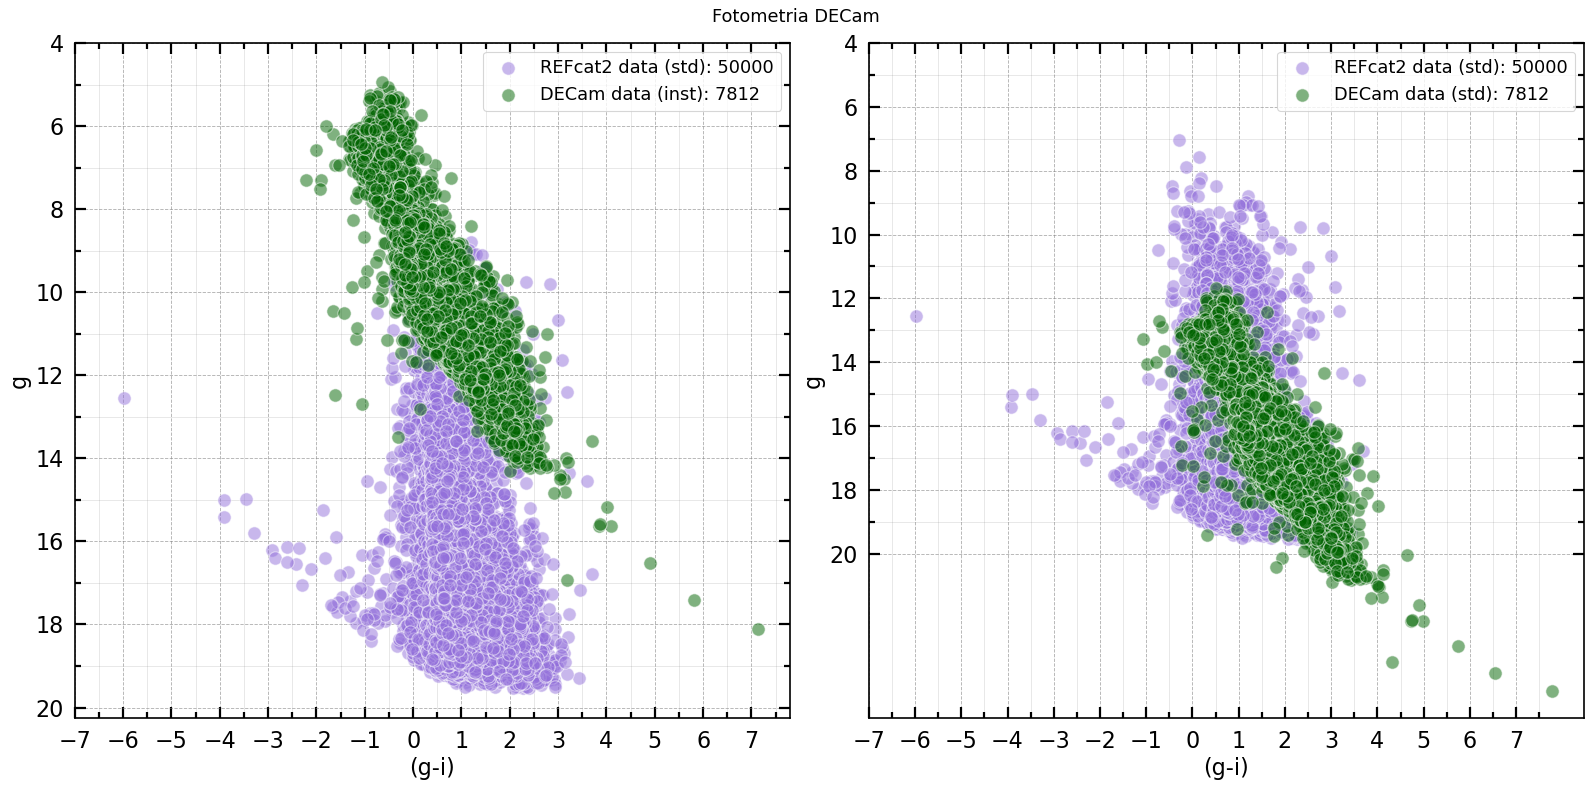

In [19]:
fig, (ax1, ax2) = plt.subplots ( ncols = 2, nrows = 1, figsize = (20, 10), dpi = 80 )
fig.suptitle ( 'Fotometria DECam', fontsize = 16 )

refcat2pandas['g-i'] = refcat2pandas['g'] - refcat2pandas['i']
for a in [ ax1, ax2 ]:
    a.scatter ( 'g-i' , 'g', data = refcat2pandas, 
               alpha = 0.5, color = 'mediumpurple', edgecolor = "white", s = 12**2, zorder = 8, 
               label = "REFcat2 data (std): %i" %(len(refcat2pandas)) )

phot['g-i_decam'] = phot['g_decam'] - phot['i_decam'] 
ax1.scatter ( 'g-i_decam' , 'g_decam', data = phot,
             alpha = 0.5, color = 'darkgreen', edgecolor = "white", s = 12**2, zorder = 9, 
             label = "DECam data (inst): %i" %(len(phot)) )

phot['g-i_decam_std'] = phot['g_decam_std'] - phot['i_decam_std'] 
ax2.scatter ( 'g-i_decam_std' , 'g_decam_std', data = phot,
             alpha = 0.5, color = 'darkgreen', edgecolor = "white", s = 12**2, zorder = 9, 
             label = "DECam data (std): %i" %(len(phot)) )

xmin, xmax = ax1.set_xlim()
ymin, ymax = ax1.set_ylim()

mkgrid ( [ax1, ax2], xmin, xmax, 1.0, 0.5, ymin, ymax, 2.0, 1.0 )

for a in [ ax1, ax2 ]:
    a.set_xlabel ( '(g-i)' )
    a.set_ylabel ( 'g' )
    a.invert_yaxis()
    a.legend ( fontsize = 16 )
    
plt.tight_layout()
plt.show()

In [20]:
fig.savefig ( 'figures/03-decam_photometry-std.png', dpi = 130, facecolor = 'w', edgecolor = 'w', orientation = 'portrait', format = None,
        transparent = False, bbox_inches = None, pad_inches = 0.1, metadata = None )

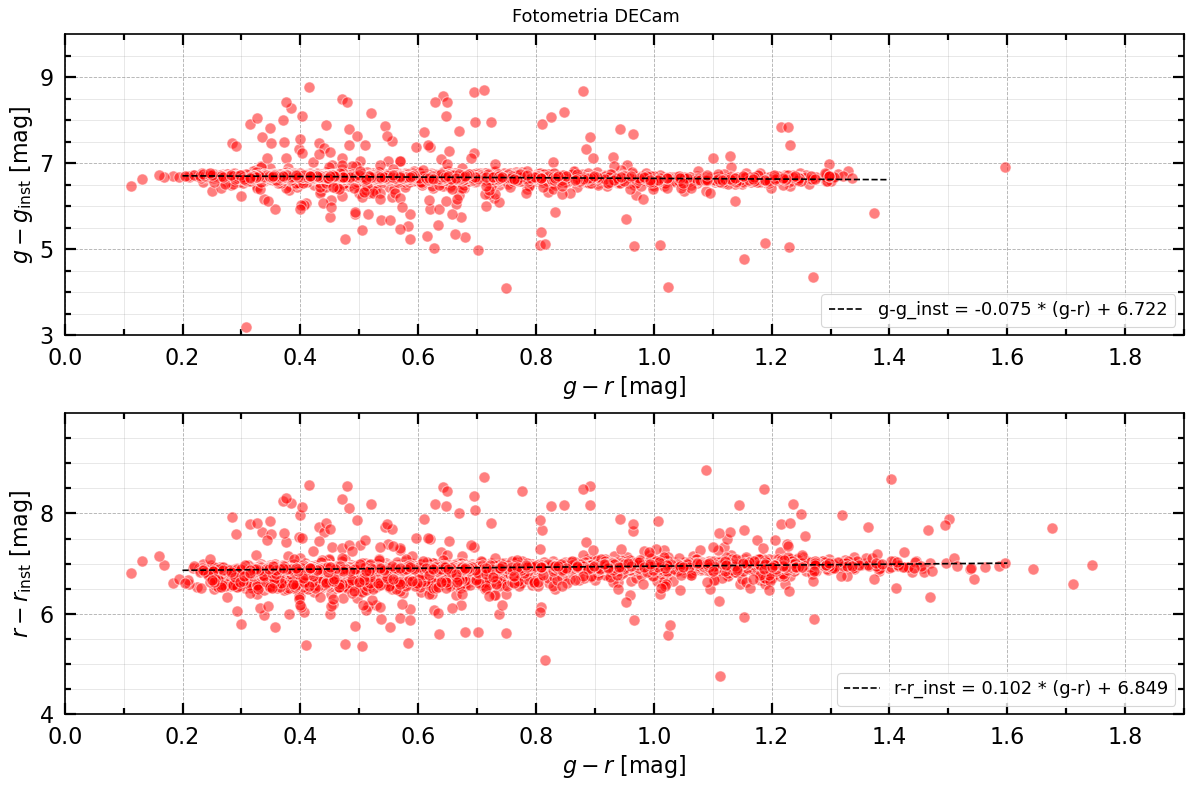

In [21]:
fig, (ax1, ax2) = plt.subplots ( ncols = 1, nrows = 2, figsize = (15, 10), dpi = 80 )
fig.suptitle ( 'Fotometria DECam', fontsize = 16 )
 
ax1.set_xlabel ( '$g-r$ [mag]' )
ax1.set_ylabel ( r'$g-g_{\rm inst}$ [mag]' )   
xmin, xmax = 0.0, 1.8 # g_gmr.min(), g_gmr.max()

ax1.scatter ( gmr, g - g_inst, 
             alpha = 0.5, color = 'red', edgecolor = "white", s = 10**2, zorder = 9 )
ymin, ymax = 3.0, 10.0 # (g - g_inst).min(), (g - g_inst).max()
ax1.set_xlim ( [ xmin, xmax ] )
ax1.set_ylim ( [ ymin, ymax ] )
mkgrid( [ax1], xmin, xmax, 0.2, 0.1, ymin, ymax, 2.0, 0.5 )

x = np.arange ( 0.2, 1.6, 0.2 )
g_l = ( 'g-g_inst = %3.3f * (g-r) + %3.3f' % (g_C, g_zp) )
ax1.plot ( x, g_C * x + g_zp, color = 'black', linestyle = 'dashed', zorder = 10, label = g_l )

ax2.set_xlabel ( '$g-r$ [mag]' )
ax2.set_ylabel ( r'$r-r_{\rm inst}$ [mag]' )   

ax2.scatter ( gmr, r - r_inst, 
             alpha = 0.5, color = 'red', edgecolor = "white", s = 10**2, zorder = 9 )

x = np.arange ( 0.2, 1.8, 0.2 )
r_l = ( 'r-r_inst = %3.3f * (g-r) + %3.3f' % (r_C, r_zp) )
ax2.plot ( x, r_C * x + r_zp, color = 'black', linestyle = 'dashed', zorder = 10, label = r_l )
 
ymin, ymax = 4.0, 10.0 # (g - g_inst).min(), (g - g_inst).max()
ax2.set_xlim ( [ xmin, xmax ] )
ax2.set_ylim ( [ ymin, ymax ] )
mkgrid( [ax2], xmin, xmax, 0.2, 0.1, ymin, ymax, 2.0, 0.5 )

for a in [ ax1, ax2 ]:
    a.legend ( loc = 'lower right', fontsize = 16 )

plt.tight_layout()
plt.show()

In [22]:
fig.savefig ( 'figures/03-g_r_calibrated.png', dpi = 130, facecolor = 'w', edgecolor = 'w', orientation = 'portrait', 
             format = None, transparent = False, bbox_inches = None, pad_inches = 0.1, metadata = None )

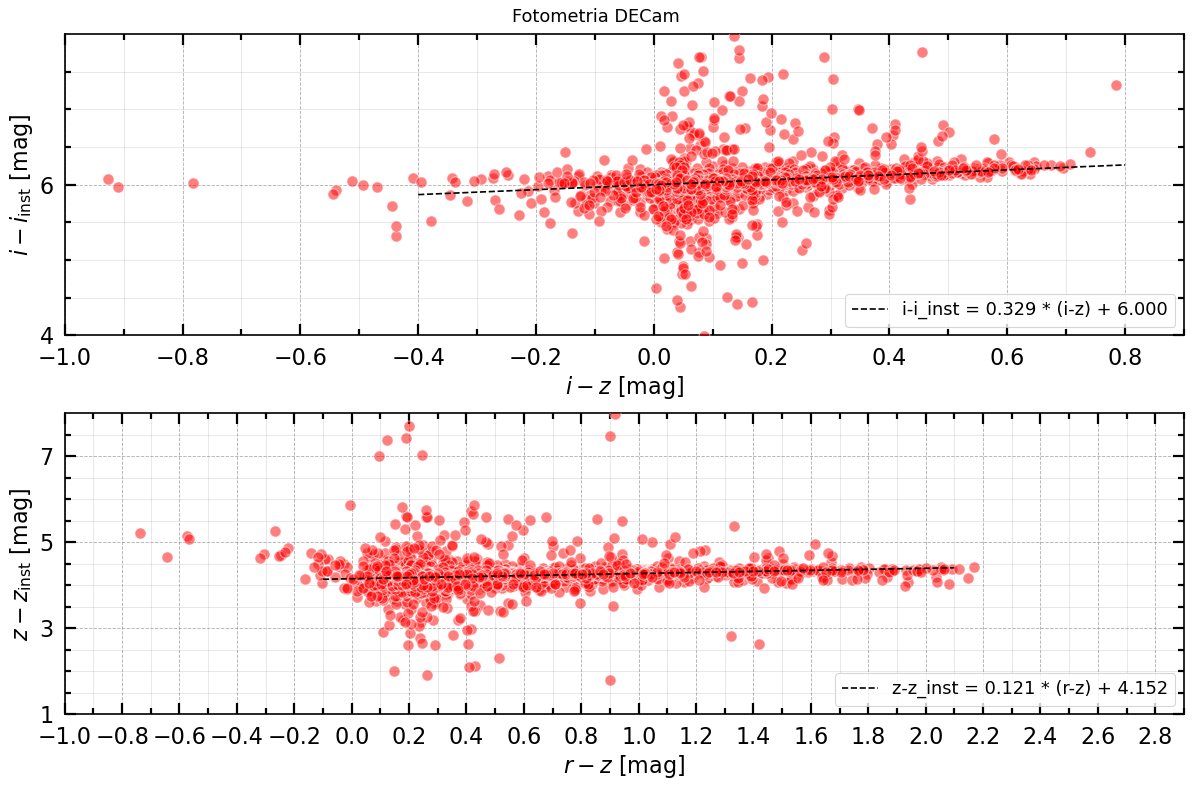

In [23]:
fig, ( ax1, ax2 ) = plt.subplots ( ncols = 1, nrows = 2, figsize = (15, 10), dpi = 80 )
fig.suptitle ( 'Fotometria DECam', fontsize = 16 )

ax1.set_xlabel ( '$i-z$ [mag]' )
ax1.set_ylabel ( r'$i-i_{\rm inst}$ [mag]' )   

ax1.scatter ( imz, i - i_inst, 
             alpha = 0.5, color = 'red', edgecolor = "white", s = 10**2, zorder = 9 )
xmin, xmax = -0.75, 0.75 # i_gmr.min(), i_gmr.max()
ymin, ymax = 4.0, 8.0 # (g - g_inst).min(), (g - g_inst).max()
ax1.set_xlim ( [ xmin, xmax ] )
ax1.set_ylim ( [ ymin, ymax ] )
mkgrid( [ax1], xmin, xmax, 0.2, 0.1, ymin, ymax, 2.0, 0.5 )

x = np.arange ( -0.4, 0.8, 0.1 )
i_l = ( 'i-i_inst = %3.3f * (i-z) + %3.3f' % (i_C, i_zp) )
ax1.plot ( x, i_C * x + i_zp, color = 'black', linestyle = 'dashed', zorder = 10, label = i_l )

ax2.set_xlabel ( '$r-z$ [mag]' )
ax2.set_ylabel ( r'$z-z_{\rm inst}$ [mag]' )   

ax2.scatter ( rmz, z - z_inst, 
             alpha = 0.5, color = 'red', edgecolor = "white", s = 10**2, zorder = 9 )

x = np.arange ( -0.1, 2.2, 0.2 )
z_l = ( 'z-z_inst = %3.3f * (r-z) + %3.3f' % (z_C, z_zp) )
ax2.plot ( x, z_C * x + z_zp, color = 'black', linestyle = 'dashed', zorder = 10, label = z_l )

xmin, xmax = -0.4, 2.3 # i_gmr.min(), i_gmr.max()
ymin, ymax = 1.0, 8.0 # (g - g_inst).min(), (g - g_inst).max()
ax2.set_xlim ( [ xmin, xmax ] )
ax2.set_ylim ( [ ymin, ymax ] )
mkgrid( [ax2], xmin, xmax, 0.2, 0.1, ymin, ymax, 2.0, 0.5 )

for a in [ ax1, ax2 ]:
    a.legend ( loc = 'lower right', fontsize = 16 )
    
plt.tight_layout()
plt.show()

In [24]:
fig.savefig ( 'figures/03-i_z_calibrated.png', dpi = 130, facecolor = 'w', edgecolor = 'w', orientation = 'portrait', format = None,
        transparent = False, bbox_inches = None, pad_inches = 0.1, metadata = None )

In [120]:
coeff = pd.DataFrame ( [["g", g_C, g_zp], ["r", r_C, r_zp], ["i", i_C, i_zp], ["z", z_C, z_zp]], columns=['filter', 'C', 'zp'])
coeff.to_pickle ( 'decam_photometry_coeff.pkl' )

In [119]:
coeff

,filter,C,zp
0,g,-0.074695,6.721712
1,r,0.101805,6.848721
2,i,0.328558,6.000128
3,z,0.121364,4.151674


---

# Función para calcular el error en la fotometria

In [7]:
"""Computes MMM statistics within photutils apertures.
The functions in this script enable the computation of statistics
within a PhotUtils aperture, which is currently not directly
implemented in PhotUtils itself.  This code is meant to be
imported into other code, and then be usable as a single line to
return all the statistics in a format similar to the
aperture_photometry method in PhotUtils (i.e. an astropy table).
Authors
-------
    - Varun Bajaj, December 2017
Use
---
    from background_median import aperture_stats_tbl
    stats_tbl = aperture_stats_tbl(data, apertures)
    See the docstring of aperture_stats_tbl for more info.
"""
import numpy as np

# WAY faster than astropy.stats.sigma_clipped_stats
from scipy.stats import sigmaclip
from astropy.table import Table
from photutils.aperture.mask import ApertureMask

def aperture_stats_tbl(data, apertures,
                       method='exact', sigma_clip=True):
    """Computes mean/median/mode/std in Photutils apertures.
    Compute statistics for custom local background methods.
    This is primarily intended for estimating backgrounds
    via annulus apertures.  The intent is that this falls easily
    into other code to provide background measurements.
    Parameters
    ----------
    data : array
        The data for the image to be measured.
    apertures : photutils PixelAperture object (or subclass)
        The phoutils aperture object to measure the stats in.
        i.e. the object returned via CirularAperture,
        CircularAnnulus, or RectangularAperture etc.
    method: str
        The method by which to handle the pixel overlap.
        Defaults to computing the exact area.
        NOTE: Currently, this will actually fully include a
        pixel where the aperture has ANY overlap, as a median
        is also being performed.  If the method is set to 'center'
        the pixels will only be included if the pixel's center
        falls within the aperture.
    sigma_clip: bool
        Flag to activate sigma clipping of background pixels
    Returns
    -------
    stats_tbl : astropy.table.Table
        An astropy Table with the colums X, Y, aperture_mean,
        aperture_median, aperture_mode, aperture_std, aperture_area
        and a row for each of the positions of the apertures.
    """

    # Get the masks that will be used to identify our desired pixels.
    masks = apertures.to_mask(method=method)
    if isinstance(masks, ApertureMask): # fix different return types
        masks = [masks]

    # Compute the stats of pixels within the masks
    aperture_stats = [calc_aperture_mmm(data, mask, sigma_clip)
                      for mask in masks]

    aperture_stats = np.array(aperture_stats)


    # Place the array of the x y positions alongside the stats
    stacked = np.hstack([apertures.positions, aperture_stats])
    # Name the columns
    names = ['X','Y','aperture_mean','aperture_median','aperture_mode',
            'aperture_std', 'aperture_area']
    # Make the table
    stats_tbl = Table(data=stacked, names=names)
    return stats_tbl

def calc_aperture_mmm(data, mask, sigma_clip):
    """Helper function to actually calculate the stats for pixels
        falling within some Photutils aperture mask on some array
        of data.
    """
    cutout = mask.cutout(data, fill_value=np.nan)
    if cutout is None:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)
    else:
        values = cutout * mask.data / mask.data
        values = values[~np.isnan(values)]
        if sigma_clip:
            values, clow, chigh = sigmaclip(values, low=3, high=3)

        mean = np.mean(values)
        median = np.median(values)
        std = np.std(values)

        mode = 3 * median - 2 * mean
        actual_area = (~np.isnan(values)).sum()
        return (mean, median, mode, std, actual_area)

def compute_phot_error(
        flux_variance,
        bg_phot,
        bg_method,
        ap_area,
        epadu=1.0):
    """Computes the flux errors using the DAOPHOT style computation"""
    bg_variance_terms = (ap_area * bg_phot['aperture_std'] ** 2. ) \
                        * (1. + ap_area/bg_phot['aperture_area'])
    variance = flux_variance / epadu + bg_variance_terms
    flux_error = variance ** .5
    return flux_error

In [10]:
def mkgrid(ax, xmin, xmax, xdelta, xxdelta, ymin, ymax, ydelta, yydelta):
    for a in ax:  
        #a.axhline ( 0, color = 'black', linestyle = '-', linewidth = 2, alpha = 0.9, zorder = -1 )

        a.set_xticks ( np.arange(np.floor(xmin), np.ceil(xmax), xdelta) )
        a.set_xticks ( np.arange(np.floor(xmin), np.ceil(xmax), xxdelta), minor = True )
        a.set_yticks ( np.arange(np.floor(ymin), np.ceil(ymax), ydelta) )
        a.set_yticks ( np.arange(np.floor(ymin), np.ceil(ymax), yydelta), minor = True )
        a.grid ( which = 'minor', color = 'gray', alpha = 0.2, linestyle = '-' )
        a.grid ( which = 'major', color = 'gray', alpha = 0.6, linestyle = '--' )

        plt.setp ( a.spines.values(), linewidth = 1.5 )
        a.tick_params ( which = 'major', direction = 'inout' )
        a.tick_params ( which = 'minor', direction = 'in' )
        a.yaxis.set_ticks_position ( 'both' )
        a.xaxis.set_ticks_position ( 'both' )
        a.tick_params ( direction = 'in', pad = 10 )  
        a.tick_params ( which = 'both', width = 2 )
        a.tick_params ( which = 'major', length = 10 )
        a.tick_params ( which = 'minor', length = 5 )
        #a.legend ( fontsize = 16 )

        for item in ([a.title, a.xaxis.label, a.yaxis.label] +
                 a.get_xticklabels() + a.get_yticklabels()):
            item.set_fontsize(20)
            
        #a.set_xlim ( [ xmin, xmax ] )
        #if a == ax1:
        #    a.set_ylim ( [ -0.5, 0.5 ] )
        #elif a==ax2:
        #    a.set_ylim ( [ -0.1, 0.8 ] )